In [40]:
import pysm
import pysm.units as u
import h5py

import matplotlib.pyplot as plt
import corner

import jax.numpy as np
from jax import grad, hessian,jit, vmap
import jax

%load_ext autoreload
%autoreload 2


from scipy.optimize import minimize
import numpy as old_np
import healpy as hp
import emcee

from hoover.seds import FMatrix
from hoover.likelihood import LogProb
from hoover.tools import WhiteNoise
from jax.config import config
config.update("jax_enable_x64", True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Simulations

Use `pysm` to generate some observed sky maps. Create sky model with the `d1` and `s1` dust and synchrotron models, respectively.

In [25]:
nside = 64
sky = pysm.Sky(nside=nside, preset_strings=["d1", "s1", "c2"])

Define the frequencies at which to observe the `pysm` model. Define the the sensitivities in $\mu K~{\rm amin}$, and convert to $\mu K_{\rm RJ}~{\rm amin}$.

In [26]:
freqs = old_np.array([27., 39., 93., 145., 225., 280.]) * u.GHz
sens = np.array([35., 21, 2.6, 3.3, 6.3, 16.]) * u.uK_CMB
sens = np.array([w.to(u.uK_RJ, equivalencies=u.cmb_equivalencies(f)) for w, f in zip(sens, freqs)])

Evaluate `pysm` model at the given frequencies. Generate white noise realizations with the given sensitivities, and add to the observed sky. Note that we have to cast the `noise.map` object to a true `numpy` array, as it is returned from `WhiteNoise` as a `jax` `DeviceArray` object.

In [27]:
fpath = 'simulations.h5'

out = np.concatenate(list(sky.get_emission(f)[None, 1:, ...] for f in freqs))
noise = WhiteNoise(sens=sens)
noise_map = old_np.asarray(noise.map(nside))
cov = noise.get_pix_var_map(nside)
noisy_obs = noise_map + out

In [28]:
with h5py.File(fpath, 'a') as f:
    grp = f.require_group('so_basic')
    dset = grp.require_dataset('data', shape=noisy_obs.shape, dtype=noisy_obs.dtype)
    dset[...] = noisy_obs
    dset = grp.require_dataset('cov', shape=cov.shape, dtype=cov.dtype)
    dset[...] = cov
    grp.attrs['frequencies'] = freqs.value

In [29]:
with h5py.File(fpath, 'r') as f:
    grp = f["so_basic"]
    data = grp['data'][...]
    cov = grp['cov'][...]
    frequencies = grp.attrs['frequencies']

# Likelihood Model

We now define the likelihood model. 

First, we set up the `FMatrix` object. This requires specifying the SED for each of the components we want to fit. Here, we fit two components, a `dustmbb` and a `syncpl` component. These must correspond to functions defined in `hoover.seds`. We also define a default set of parameter values for these SEDs. We can change the likelihood to be a function of any of these parameters later.  

Also define the Gaussian priors on each of the parameters we want to allow to vary. The format for this is a dictionary with keys corresponding to the parameter name, and values being a tuple containing the mean and standard deviation of the prior.

Initialize the `LogProb` object. This object calculates the spectral parameter likelihood, having marginalized over amplitudes:

$$
\log \mathcal{L}\left(\mathbf{b} | \mathbf{d} \right) \propto p_p(\mathbf{b}) \exp(\frac{1}{2} \bar{\mathbf{T}}^T N_T^{-1} \bar{\mathbf{T}})
$$

In [55]:
lnP = LogProb()
lnP.load_data_from_hdf5("simulations.h5", "so_basic")
lnP.load_model_from_yaml("../configs/fitting.yaml")

In [56]:
lnp_jit = jit(lnP)

In [57]:
%timeit lnp_jit([1.5, -3.]).block_until_ready()

120 ms ± 11.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [58]:
%timeit lnP([1.5, -3])

The slowest run took 11.41 times longer than the fastest. This could mean that an intermediate result is being cached.
78.5 ms ± 31.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


As a sanity check, lets see if setting $\beta_d$ and $\beta_s$ to a constant (across the sky) value gives reasonable-looking dust and synchrotron maps:

In [59]:
dust, sync, cmb = sky.components

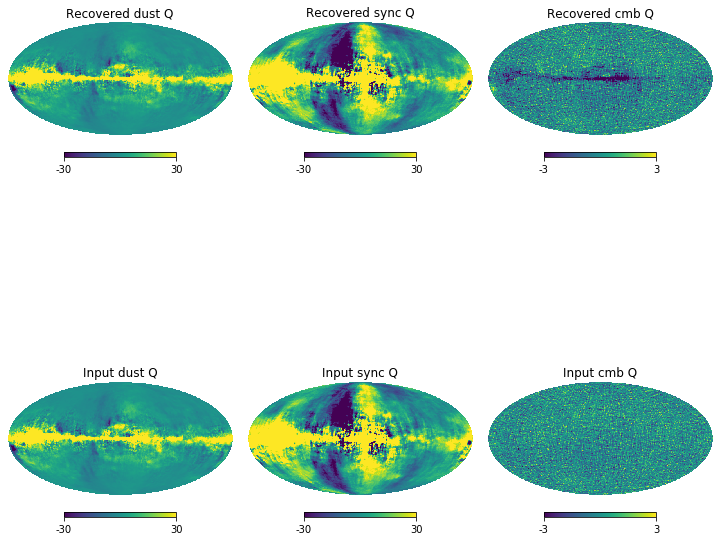

In [60]:
dust, sync, cmb = sky.components # input maps to the simulation
tbar = lnP.get_amplitude_expectation([1.45, -3.]) # T_bar evaluated for constant spectral index

fig = plt.figure(figsize=(10, 10))
hp.mollview(tbar[0, 0], sub=(231), min=-30, max=30, title="Recovered dust Q")
hp.mollview(tbar[1, 0], sub=232, min=-30, max=30, title="Recovered sync Q")
hp.mollview(tbar[2, 0], sub=233, min=-3, max=3, title="Recovered cmb Q")
hp.mollview(old_np.asarray(dust.Q_ref), sub=(234), min=-30, max=30, title="Input dust Q")
hp.mollview(old_np.asarray(sync.Q_ref), sub=235, min=-30, max=30, title="Input sync Q")
hp.mollview(old_np.asarray(cmb.map[1]), sub=236, min=-3, max=3, title="Input cmb Q")

The `d1` and `s1` `pysm` models have spatially varying spectral indices, but so far we have modelled them as constant, so we have some residuals when differencing the maps (in addition to the noise resiudals you would expect in any case):

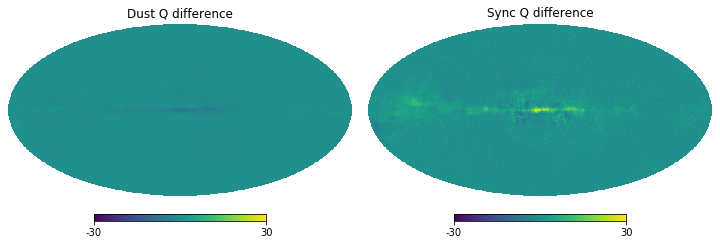

In [61]:
fig = plt.figure(figsize=(10, 5))
hp.mollview(tbar[0, 0] - old_np.asarray(dust.Q_ref), sub=(121), min=-30, max=30, title="Dust Q difference")
hp.mollview(tbar[1, 0] - old_np.asarray(sync.Q_ref), sub=122, min=-30, max=30, title="Sync Q difference")

# Inference with the likelihood 

The likelihood object `LogProb` can be thought of as a function of any subset of spectral parameters.

The likelihood code is implemented in `jax`, which allows us to take derivatives of the likelihood with respect to any of the SED parameters.

In [62]:
gfunc = grad(lambda t: lnP(t, True))
hfunc = hessian(lnP)
theta_0 = lnP.theta_0(seed=123)
print(theta_0)

[ 1.48475083 -2.950711  ]


We can maximize the likelihood with respect to the spectral parameters $\beta_d$, $\beta_s$. Note that we have to pass the `ret_neg=True` argument to `lnP` in order to get the negative log likelihood:

In [63]:
res = minimize(lprob, theta_0, jac=True, method='BFGS')

In [64]:
print(res)

fun: -4713389823.168249
 hess_inv: array([[ 1.81916389e-08, -2.69994730e-08],
       [-2.69994730e-08,  2.86312812e-07]])
      jac: DeviceArray([-0.20477966,  0.24348418], dtype=float64)
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 61
      nit: 5
     njev: 49
   status: 2
  success: False
        x: array([ 1.53327846, -2.9416068 ])


In [65]:
with h5py.File('simulations.h5', 'a') as f:
    grp = f['so_basic']
    fit = grp.require_group('fitting')
    fit.attrs.clear()
    fit.attrs.update(res)

And make a Fisher estimate of the uncertainties in the ML values:

In [66]:
hess = hfunc(res.x)

In [67]:
fish = np.linalg.inv(-hess)
print(np.sqrt(fish))

[[0.00013485        nan]
 [       nan 0.00053464]]


How does this compare to if we sampled the posterior?

In [44]:
ndim, nwalkers = 2, 10
key = jax.random.PRNGKey(748)
# set an array of starting positions for the different walkers
theta_0 = lnP.theta_0(seed=1000)

In [45]:
# define the posterior to sample from
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnP)
sampler.run_mcmc(p0, 500)

State([[ 1.53335196 -2.94185448]
 [ 1.53327399 -2.94123394]
 [ 1.53303504 -2.94149337]
 [ 1.53308963 -2.94173768]
 [ 1.5335365  -2.94139199]
 [ 1.53324375 -2.94153281]
 [ 1.53347833 -2.94178552]
 [ 1.53326735 -2.94180108]
 [ 1.53334332 -2.94174198]
 [ 1.53332589 -2.94153947]], log_prob=[4.71338982e+09 4.71338982e+09 4.71338982e+09 4.71338982e+09
 4.71338982e+09 4.71338982e+09 4.71338982e+09 4.71338982e+09
 4.71338982e+09 4.71338982e+09], blobs=None, random_state=('MT19937', array([1696670620, 1183972689, 1922021722, 3819774033, 2645196390,
       4252033244, 1456475634, 1879860744,  163840505, 2338491290,
        556455214, 4283658636, 4000297391, 1113208794, 1626560968,
       3234602157, 1198560828,   29850998,   98596661, 2922274831,
        239169966, 4185619266, 2214785775, 1912423998, 2720119923,
       2387364313, 3784317576, 1269447800, 4206398384, 3990602927,
       2429624303,  172084282, 1123264682, 1839168027, 2437967953,
       1039985578, 3218300656, 2338272981, 114178984

In [ ]:
max_n = 100000

# We'll track how the average autocorrelation time estimate changes
index = 0
autocorr = np.empty(max_n)

# This will be useful to testing convergence
old_tau = np.inf

# Now we'll sample for up to max_n steps
for sample in sampler.sample(p0, iterations=max_n, progress=True):
    # Only check convergence every 100 steps
    if sampler.iteration % 100:
        continue

    # Compute the autocorrelation time so far
    # Using tol=0 means that we'll always get an estimate even
    # if it isn't trustworthy
    tau = sampler.get_autocorr_time(tol=0)
    autocorr[index] = np.mean(tau)
    index += 1

    # Check convergence
    converged = np.all(tau * 100 < sampler.iteration)
    converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
    if converged:
        break
    old_tau = tau

In [49]:
chain = sampler.get_chain(flat=True, discard=100)
print(chain.shape)

(4000, 2)


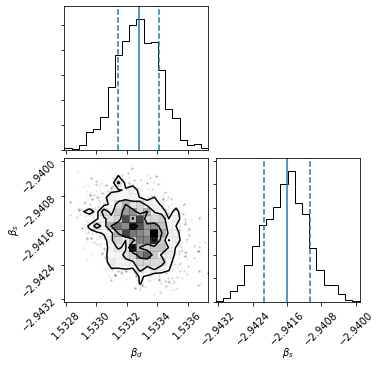

In [47]:
fig = corner.corner(chain, labels=[r'$\beta_d$', r'$\beta_s$'])
axes = fig.axes
xs = np.arange(*axes[0].get_xlim())
beta_d_fish = np.sqrt(fish[0, 0])
beta_s_fish = np.sqrt(fish[1, 1])

axes[0].axvline(x=res.x[0])
axes[0].axvline(x=res.x[0] - np.sqrt(fish[0, 0]), ls='--')
axes[0].axvline(x=res.x[0] + np.sqrt(fish[0, 0]), ls='--')

axes[-1].axvline(x=res.x[1])
axes[-1].axvline(x=res.x[1] - np.sqrt(fish[1, 1]), ls='--')
axes[-1].axvline(x=res.x[1] + np.sqrt(fish[1, 1]), ls='--')

In [48]:
out = np.mean(vmap(lnP.get_amplitude_expectation)(chain), axis=0)

RuntimeError: Resource exhausted: Failed to allocate request for 26.37GiB (28311552000B) on device ordinal 0

In [42]:
print(out.shape)

(3, 2, 49152)


In [89]:
out = np.zeros((3, 2, hp.nside2npix(nside)))
for pars in chain:
    out += lnP.get_amplitude_expectation(parameters, beta_d=pars[0], beta_s=pars[1])
out = out / float(chain.shape[0])

Finally let's plot the expected component amplitudes, $\langle \bar T | \mathbf{d} \rangle$:

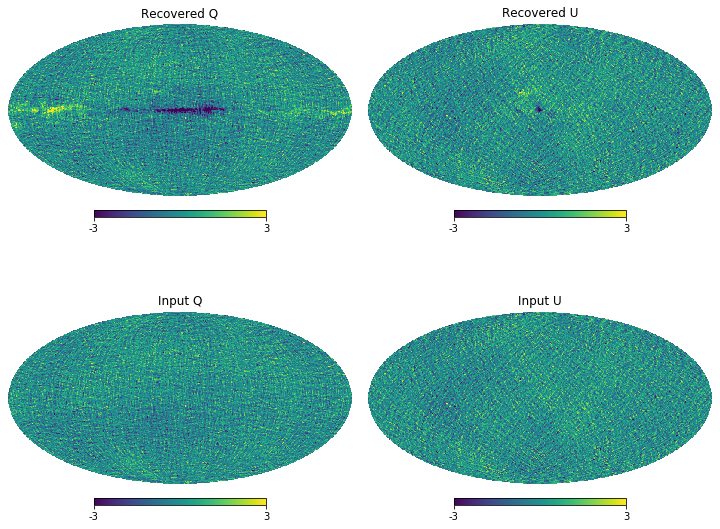

In [43]:
fig = plt.figure(figsize=(10, 8))
kwargs = {'min': -3, 'max': 3}
hp.mollview(out[2, 0], sub=221, **kwargs, title='Recovered Q')
hp.mollview(out[2, 1], sub=222, **kwargs, title='Recovered U')
hp.mollview(cmb.map[1], sub=223, **kwargs, title='Input Q')
hp.mollview(cmb.map[2], sub=224, **kwargs, title='Input U')